# Waveform visualization

In [1]:
import sys
import os
import time
import datetime

import tables            as tb
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from   invisible_cities.database               import load_db
import invisible_cities.reco.peak_functions_c  as     cpf
from   invisible_cities.reco.params            import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
import invisible_cities.sierpe.blr             as     blr

print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


2017-05-31 16:27:44


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["figure.figsize"]          = 18, 12
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

## Configuration

In [4]:
filename      = "/home/brais/Documents/Next/Alpha/wf/dst_waves.gdcsnext.000_4150.root.h5"
event_0       = 0
event_f       = 3
event_display = 1

In [5]:
dataPMT    = load_db.DataPMT(4150)
channel_id =            dataPMT.ChannelID .values.astype(np.double)
sensor_id  =            dataPMT.SensorID  .values.astype(np.double)
pmt_id     =            dataPMT.PmtID     .values.astype(np.str)
coeff_blr  =            dataPMT.coeff_blr .values.astype(np.double)
coeff_c    =            dataPMT.coeff_c   .values.astype(np.double)
adc_to_pes = np.abs    (dataPMT.adc_to_pes.values.astype(np.double))
pmt_active = np.nonzero(dataPMT.Active    .values)[0].tolist()

In [6]:
adc_to_pes

array([ 25.7701,  26.8967,  27.8411,  28.448 ,  30.4163,  24.0598,
        26.7696,  37.4034,  24.7545,  21.6441,  24.3859,   0.    ])

## Useful functions

In [60]:
def plot_pmt_waveforms(pmtwfdf, zoom=False, window=500, RAW=False):
    """Take as input a vector storing the PMT wf and plot the waveforms"""
    fig, ax = plt.subplots(4,3, sharex='col', sharey='row')
    k = -1
    loc = 2 if not RAW else 3
    for i in range(len(pmtwfdf)):
        j = i%3
        if j==0: k += 1
        if not pmtwfdf[i,0]:
            pass
        else:  
            t = np.arange(len(pmtwfdf[i]))*25e-3
            if not zoom:
                ax[k,j].plot(t, pmtwfdf[i])
            else:
                pos_max   = np.argmax(pmtwfdf[i])
                t_window  = t[pos_max-window:pos_max+window]
                wf_window = pmtwfdf[i][pos_max-window:pos_max+window]
                ax[k,j].plot(t_window, wf_window)
        ax[k,j].legend((pmt_id[i][3]), loc=loc)
    fig.subplots_adjust(hspace=0,wspace=0)
    return fig

## Reading data

In [8]:
with tb.open_file(filename) as h5in:
        #print(h5in)
        wf = h5in.root.RD.pmtrwf[event_0:event_f]
        
#wf = lifetimes[coref.in_range(lifetimes.Run, min_run, max_run+1)]


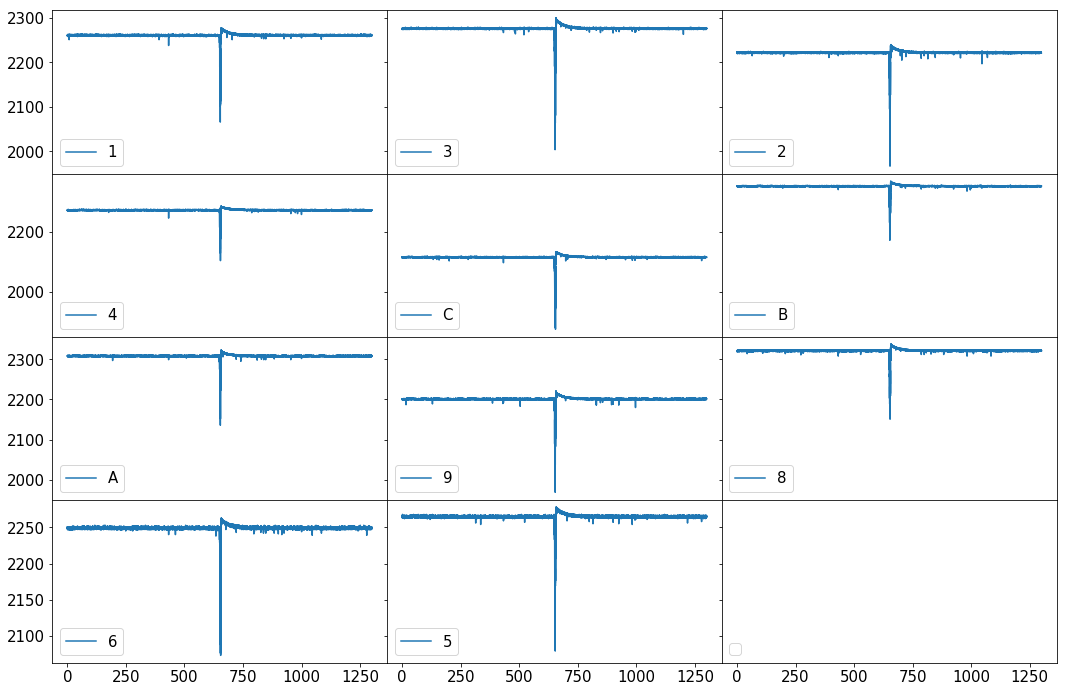

In [9]:
plot_pmt_waveforms(wf[0], RAW=True);

In [10]:
CWF = blr.deconv_pmt(wf[0],
                             coeff_c,
                             coeff_blr,
                             pmt_active,
                             n_baseline  = 48000,
                             thr_trigger = 5)
CWF.shape

(11, 52000)

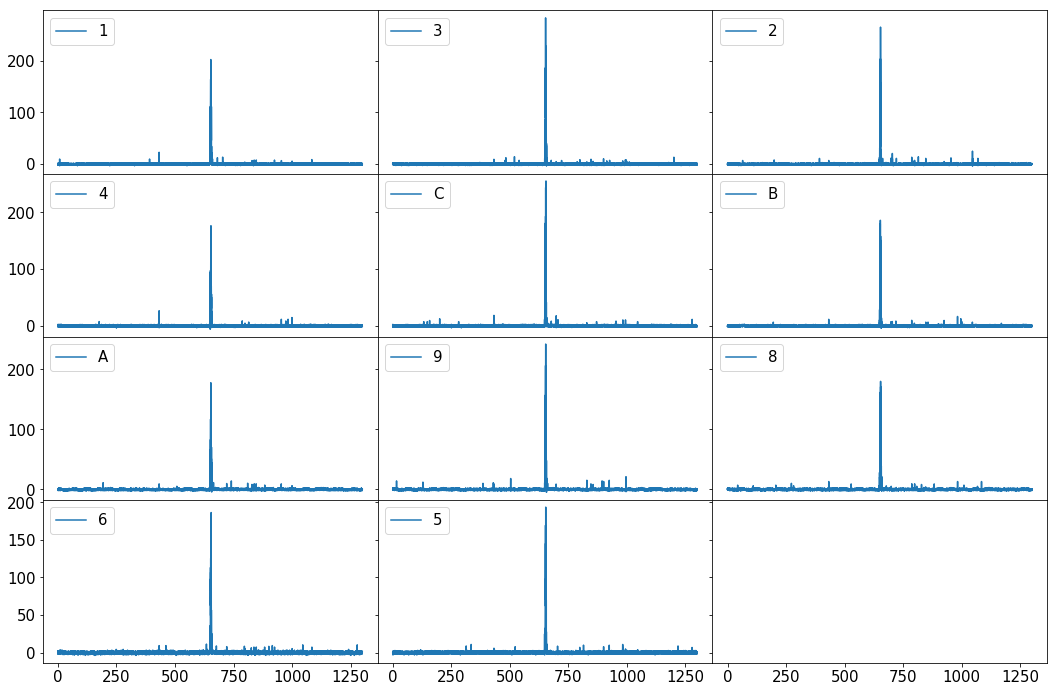

In [11]:
plot_pmt_waveforms(CWF);

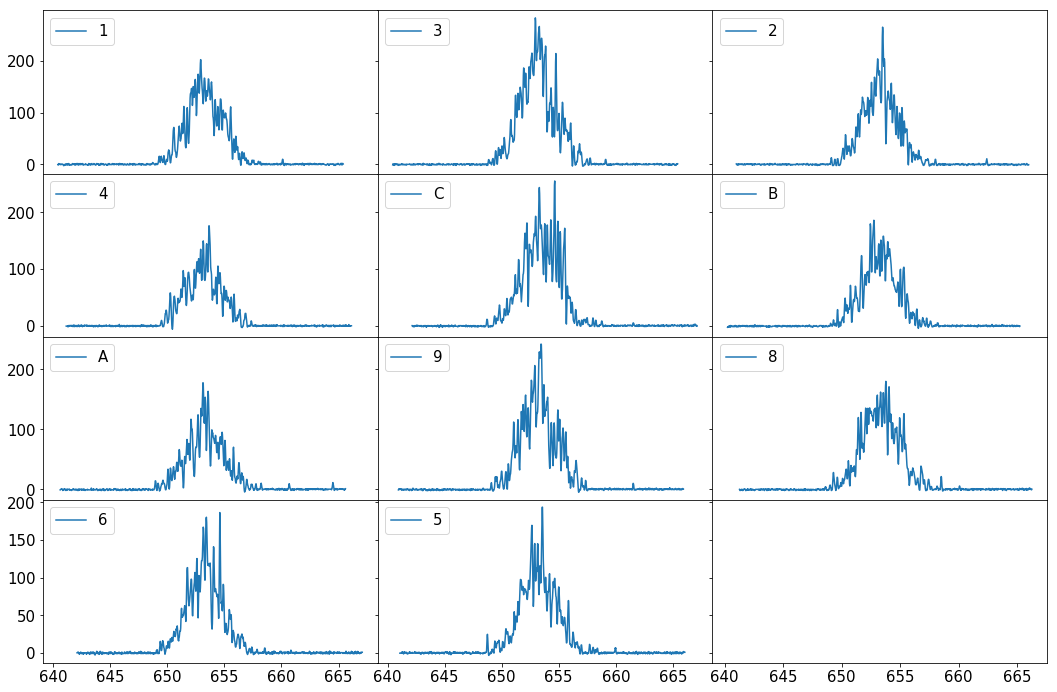

In [12]:
plot_pmt_waveforms(CWF,1,500);

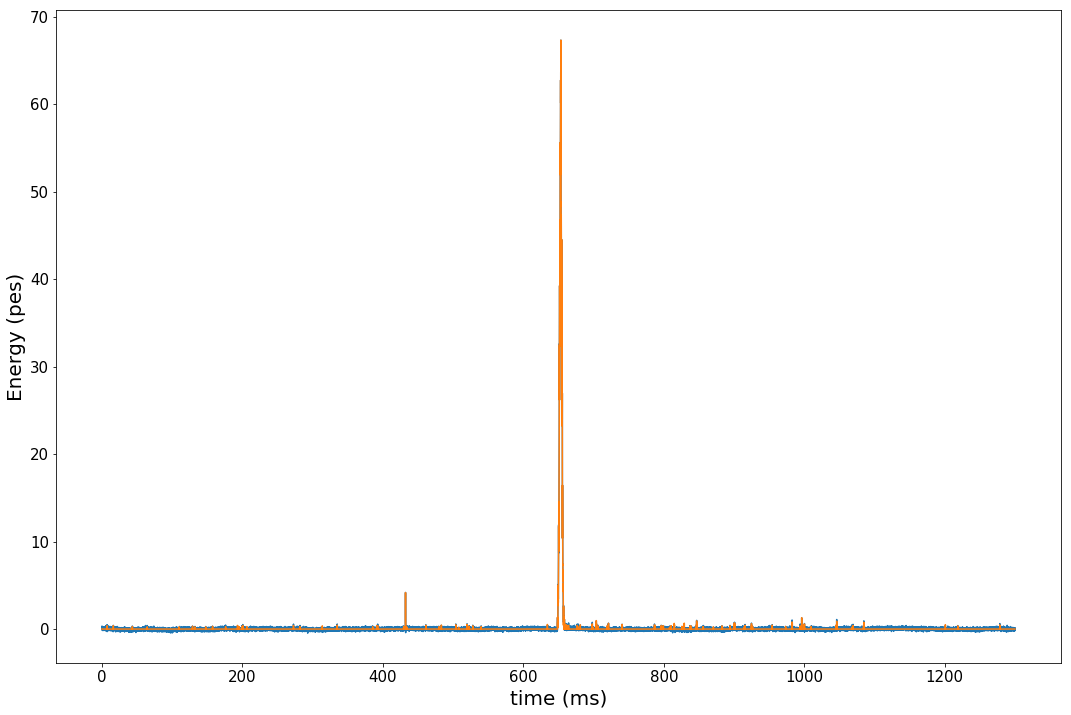

In [64]:
csum_wf, csum_mau_wf  = cpf.calibrated_pmt_sum(CWF, adc_to_pes, pmt_active, n_MAU = 100, thr_MAU =5)
plt.plot(np.arange(len(csum_wf))*25e-3, csum_wf)
plt.xlabel('time (ms)'   , fontsize=20)
plt.ylabel('Energy (pes)', fontsize=20)
plt.plot(np.arange(len(csum_mau_wf))*25e-3, csum_mau_wf)
plt.xlabel('time (ms)'   , fontsize=20)
plt.ylabel('Energy (pes)', fontsize=20)

## S1 and S2 searches


In [65]:
s1_ene, s1_indx = cpf.wfzs(csum_mau_wf, threshold = 0.2 * units.adc)
s2_ene, s2_indx = cpf.wfzs(csum_wf    , threshold = 1.0 * units.adc)

# In a few rare cases s2_ene is empty
# this is due to empty energy plane events
# a protection is set to avoid a crash
#if np.sum(s2_ene) == 0:
 #   self.empty_events += 1
  #  continue

In [66]:
s1par = S12Params(tmin=0.*units.mus, tmax=640.*units.mus, lmin=6, lmax=40, stride=10, rebin=False)
S1 = cpf.find_S12(s1_ene, s1_indx, rebin_stride=40, **s1par._asdict())
S1 = cpf.correct_S1_ene(S1, csum_wf)

In [75]:
print(len(s1_indx))
print(s1_indx)
print(S1)

852
[  295   296   297   653   654   655  1736  1737  1738  2584  2585  4395
  5161  5162  5163  5298  5299  5912  6303  6304  6305  7047  7048  7049
  7724  7725  7726  7727  7821  7966  7967  8024  8025  8026  8027  8250
  8251 10912 10913 10914 11264 11265 11266 11285 11286 11287 12553 12554
 12555 12556 13405 13406 13407 15421 15422 15423 15656 15657 15658 15707
 15708 15709 15710 17186 17187 17188 17289 17290 17291 17292 17293 17294
 17295 17296 17297 17298 17360 17361 17362 18451 18452 18453 19202 19203
 19204 19334 19335 19336 20154 20155 20156 20157 20796 20797 20798 20799
 20916 20917 21122 21123 21124 21125 21600 21601 25370 25371 25372 25373
 25947 25948 25949 25950 25951 25952 25953 25954 25955 25956 25957 25958
 25959 25960 25961 25963 25964 25965 25966 25967 25968 25969 25970 25971
 25972 25973 25974 25975 25976 25977 25978 25979 25980 25981 25982 25983
 25984 25985 25986 25987 25988 25989 25990 25991 25992 25993 25994 25995
 25996 25997 25998 25999 26000 26001 26002 2600

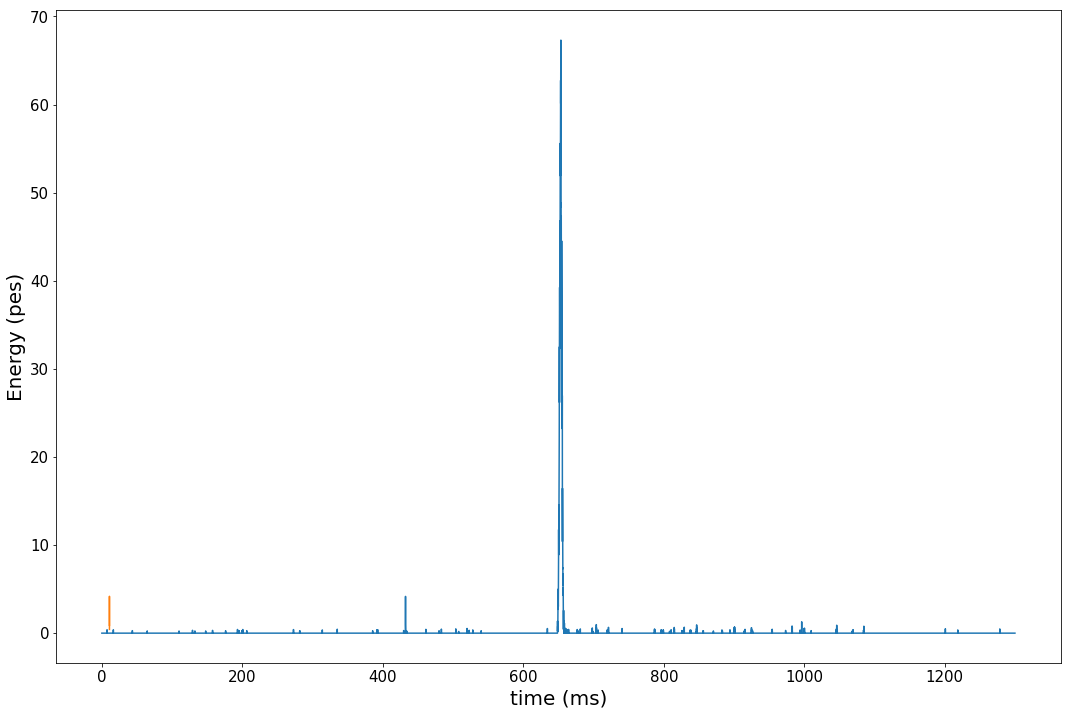

In [58]:
plt.plot(np.arange(len(sum_wf2[1]))*25e-3, sum_wf2[1])
plt.xlabel('time (ms)'   , fontsize=20)
plt.ylabel('Energy (pes)', fontsize=20)
x,y = S1[0]
plt.plot((x)*25e-6, y)
plt.xlabel('time (ms)'   , fontsize=20)
plt.ylabel('Energy (pes)', fontsize=20)

In [14]:
s1par = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=6, lmax=40, stride=10, rebin=False)